## Importation des librairies

In [9]:
%%capture capt
!pip install lifelines
!pip install tqdm
from tqdm import tqdm
import numpy as np
import pandas as pd
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter

## Base Tristan

In [262]:
profil_patient=pd.read_csv("../data/profil_patient.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)

In [263]:
profil_patient

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster
0,P0,2011-11-22,1949,11,1,NaN,False,2596,9,0,23,1,1,1,0
1,P6,2013-12-05,1929,14,2,2015-03,True,456,8,0,51,2,1,1,1
2,P8,2015-07-02,1967,54,2,2015-08,True,41,3,1,43,0,1,1,2
3,P13,2011-05-19,1959,974,1,NaN,False,2783,2,0,3,0,1,0,3
4,P16,2010-03-18,1947,76,1,NaN,False,3210,9,0,28,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10046,P24302,2014-02-08,1920,29,1,2014-12,True,318,8,0,47,2,1,1,12
10047,P24303,2012-02-09,1927,61,1,2017-05,True,1924,12,0,86,2,2,2,6
10048,P24304,2010-07-27,1924,999,1,2010-08,True,5,1,0,10,2,0,1,13
10049,P24308,2011-11-25,1925,13,2,2013-03,True,484,7,0,99,2,1,2,1


In [264]:
data=profil_patient[['Nb_survie','Mort','CHOC','cluster','BEN_SEX_COD']]
data_train=data.loc[:0.8*data['Nb_survie'].size]
data_test=data.loc[0.8*data['Nb_survie'].size:]

In [265]:
cph = CoxPHFitter(penalizer=0.9)
cph.fit(data_train, duration_col='Nb_survie', event_col='Mort', strata='CHOC')
cph.print_summary(model="spline_model")

model,lifelines.CoxPHFitter
duration col,'Nb_survie'
event col,'Mort'
penalizer,0.9
l1 ratio,0.0
strata,CHOC
baseline estimation,breslow
number of observations,8041
number of events observed,5303
partial log-likelihood,-43545.69
time fit was run,2023-02-05 21:13:25 UTC


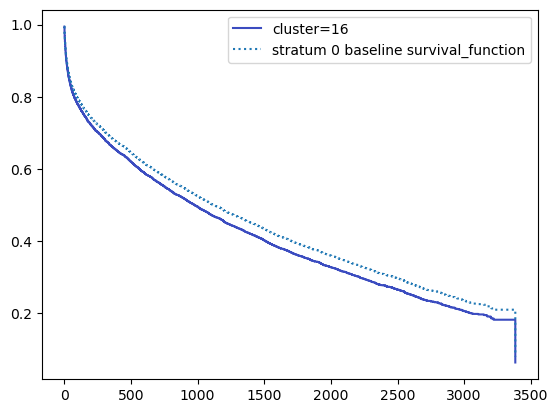

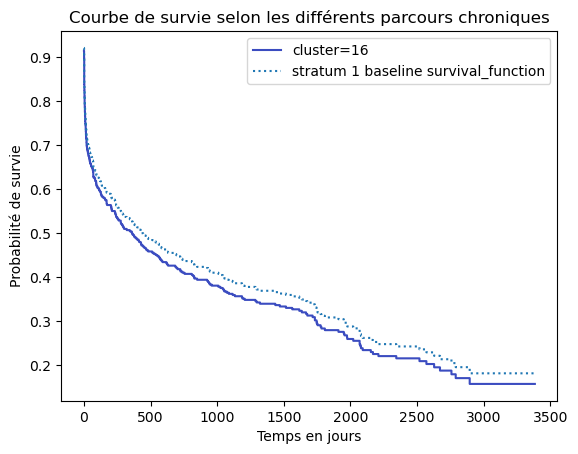

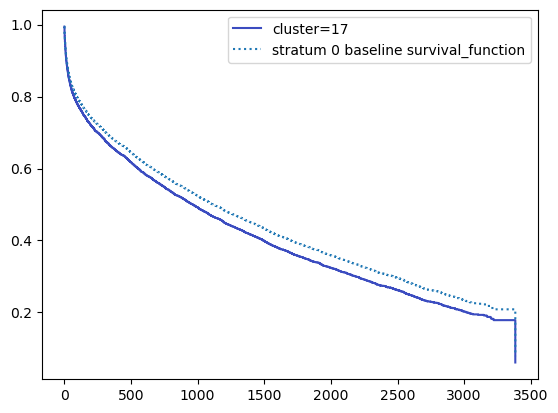

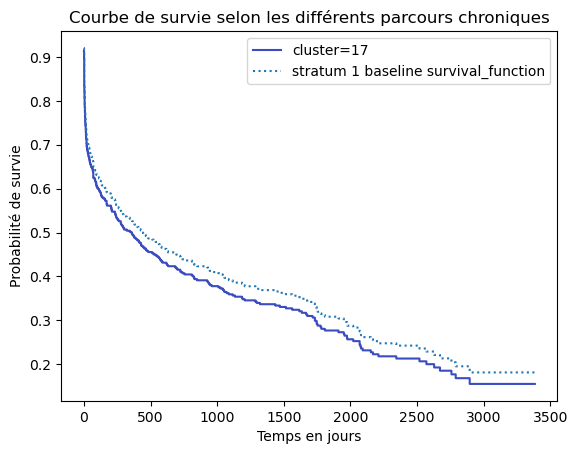

In [266]:
for i in range(16,18): 
        cph.plot_partial_effects_on_outcome(covariates=['cluster'], values=[i], cmap='coolwarm')
        plt.title("Courbe de survie selon les différents parcours chroniques")
        plt.xlabel("Temps en jours")
        plt.ylabel("Probabilité de survie")

<AxesSubplot: xlabel='log(HR) (95% CI)'>

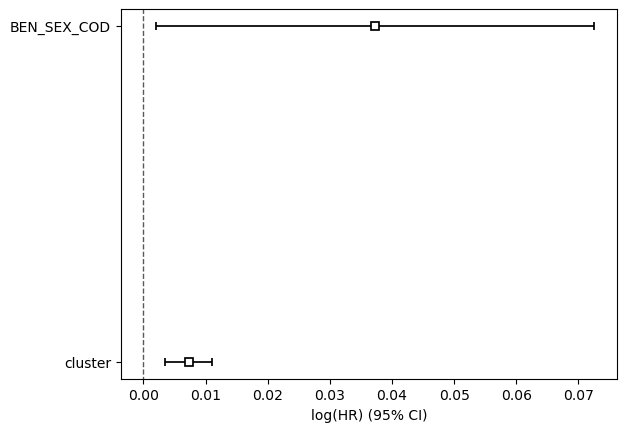

In [267]:
cph.plot()

In [91]:
cph.params_

covariate
cluster        0.007425
BEN_SEX_COD    0.037362
Name: coef, dtype: float64

Pour la variable cluster:


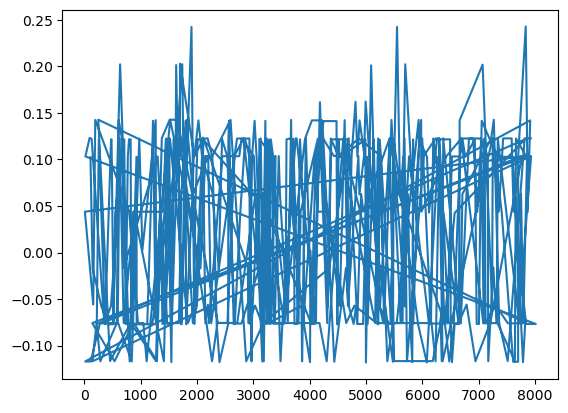

(array([43.20119264]), array([0.33617698]), array([43.03468568]), array([0.3426528]))
p-valeur du test de Ljung-Box: [0.33617698]
p-valeur du test de Box-Pierce test: [0.33617698]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:


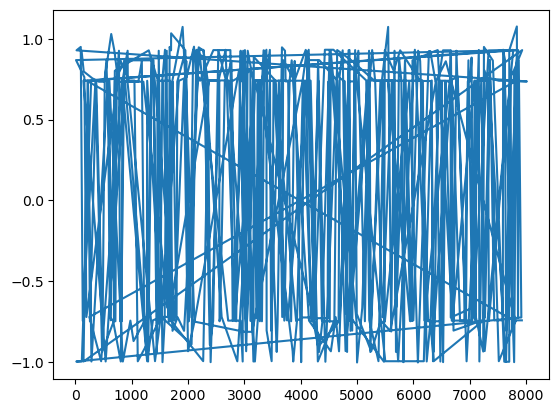

(array([47.56889989]), array([0.19171761]), array([47.37520106]), array([0.1970305]))
p-valeur du test de Ljung-Box: [0.19171761]
p-valeur du test de Box-Pierce test: [0.19171761]
Cela doit être plus grand que 0.05


In [268]:
#Use Lifelines to calculate the variance scaled Schoenfeld residuals for all regression variables in one go:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train, kind='scaled_schoenfeld')
#print(scaled_schoenfeld_residuals)
import statsmodels.stats.diagnostic as diag
Variables=['cluster','BEN_SEX_COD']
for variable in Variables:
    print('Pour la variable ' + str(variable) + ':')
    #Let's plot the residuals for AGE against time:
    plt.plot(scaled_schoenfeld_residuals.index[:500], scaled_schoenfeld_residuals[variable][:500])
    plt.show()
    #Run the Ljung-Box test to test for auto-correlation in residuals up to lag 40
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[40], boxpierce=True, model_df=0, period=None, return_df=None)
    print(result)
    print('p-valeur du test de Ljung-Box: ' + str(result[1]))
    print('p-valeur du test de Box-Pierce test: ' + str(result[1]))
    print('Cela doit être plus grand que 0.05')

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8041 total observations, 2738 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic      p  -log2(p)
BEN_SEX_COD km              0.20   0.66      0.61
            rank            0.58   0.45      1.17
cluster     km              3.63   0.06      4.14
            rank           13.27 <0.005     11.86



1. Variable 'cluster' failed the non-proportional test: p-value is 0.0003.

   Advice 1: the functional form of the variable 'cluster' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'cluster' using pd.cut, and then specify it in
`strata=['cluster', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_

[[<AxesSubplot: xlabel='rank-transformed time\n(p=0.0003)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0569)'>]]

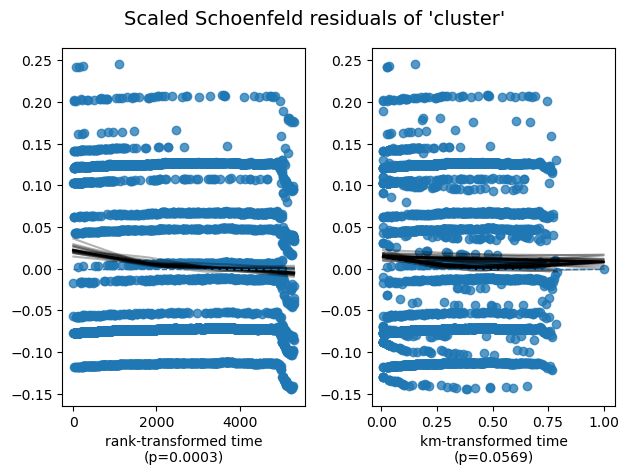

In [269]:
cph.check_assumptions(data_train, p_value_threshold=0.05, show_plots=True)

In [270]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(cph.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(cph.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
0.4450353961311349
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
1.1219489731464736
